In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import torch.nn.init as init

In [7]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


In [8]:
from google.colab import drive
drive.mount('/content/drive')

X_test = np.load("/content/drive/MyDrive/project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/project/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/project/person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

X_train_valid = X_train_valid[:, :, :500]
X_test = X_test[:, :, :500]


# modify labels to be 0-3
y_train_valid -= 769
y_test -= 769


ind_valid = np.random.choice(2115, 300, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(X_train, X_val) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_val) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',X_train.shape)
print('Shape of validation set:',X_val.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_val.shape)

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).view(-1, 22, 500), torch.from_numpy(y_train))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).view(-1, 22, 500), torch.from_numpy(y_val))
X_test = torch.from_numpy(X_test).view(-1, 22, 500)
y_test = torch.from_numpy(y_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
Shape of training set: (1815, 22, 500)
Shape of validation set: (300, 22, 500)
Shape of training labels: (1815,)
Shape of validation labels: (300,)


## LSTM

3 LSTM blocks achieve 65.7% accuracy

In [29]:
class SmallBlock (nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=False, norm=False):
        super(SmallBlock, self).__init__()
        self.norm = norm
        self.dropout = dropout

        # lstm -> relu -> (norm) -> pool -> dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(3)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.relu1(x)
        x = self.maxpool1(x.permute(0, 2, 1)).permute(0, 2, 1)

        if (self.norm):
            x = self.bn1(x.permute(0, 2, 1)).permute(0, 2, 1)
        if (self.dropout):
            x = self.drop1(x)
        return x

class BasicLSTM(nn.Module):
    def __init__(self, input_size=22, hidden_size=128, num_layers=1, num_classes=4):
        super(BasicLSTM, self).__init__()

        # LSTM layer
        self.block1 = SmallBlock(22, 128, dropout=True, norm=False)
        self.block2 = SmallBlock(128, 256, dropout=True, norm=False)
        self.block3 = SmallBlock(256, 512, dropout=True, norm=True)
        self.output = nn.Linear(512 * 18, 4)


    def forward(self, x):

        x = x.permute(0, 2, 1)

        # Forward propagate LSTM
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.reshape(x.size(0), -1)
        x = self.output(x)

        # Decode the hidden state of the last time step
        return x

In [30]:
model = BasicLSTM().to(device)
bsz, num_channels, width = 64, 22, 500
test_input = torch.randn(bsz, num_channels, width).to(device)

print(model(test_input).shape)

def weights_init(m):
    if isinstance(m, (nn.LSTM, nn.Linear)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

model.apply(weights_init)

torch.Size([64, 4])


BasicLSTM(
  (block1): SmallBlock(
    (lstm1): LSTM(22, 128, batch_first=True)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (block2): SmallBlock(
    (lstm1): LSTM(128, 256, batch_first=True)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (block3): SmallBlock(
    (lstm1): LSTM(256, 512, batch_first=True)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features

In [31]:
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

In [32]:
num_epochs = 50
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    # Set model to train mode - useful for layers such as BatchNorm or Dropout whose behaviors change between train/eval
    model.train()
    train_count = 0
    train_correct_count = 0
    train_loss = 0
    val_count = 0
    val_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        train_loss += loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc)

    model.eval()
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            loss = cel_loss(logits, val_y)
            val_loss += loss
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_acc)
    scheduler.step()


    print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")

Epoch 1, Train loss: 1.966, Train acc: 0.319, Val loss: 1.361, Val acc: 0.290
Epoch 2, Train loss: 1.558, Train acc: 0.405, Val loss: 1.305, Val acc: 0.360
Epoch 3, Train loss: 1.378, Train acc: 0.489, Val loss: 1.177, Val acc: 0.447
Epoch 4, Train loss: 1.160, Train acc: 0.547, Val loss: 1.246, Val acc: 0.467
Epoch 5, Train loss: 1.041, Train acc: 0.567, Val loss: 1.142, Val acc: 0.477
Epoch 6, Train loss: 0.934, Train acc: 0.617, Val loss: 1.182, Val acc: 0.450
Epoch 7, Train loss: 0.935, Train acc: 0.618, Val loss: 1.173, Val acc: 0.530
Epoch 8, Train loss: 0.890, Train acc: 0.632, Val loss: 0.940, Val acc: 0.607
Epoch 9, Train loss: 0.833, Train acc: 0.660, Val loss: 0.929, Val acc: 0.640
Epoch 10, Train loss: 0.803, Train acc: 0.675, Val loss: 0.879, Val acc: 0.640
Epoch 11, Train loss: 0.790, Train acc: 0.683, Val loss: 0.891, Val acc: 0.610
Epoch 12, Train loss: 0.774, Train acc: 0.700, Val loss: 1.052, Val acc: 0.573
Epoch 13, Train loss: 0.757, Train acc: 0.716, Val loss: 0.86

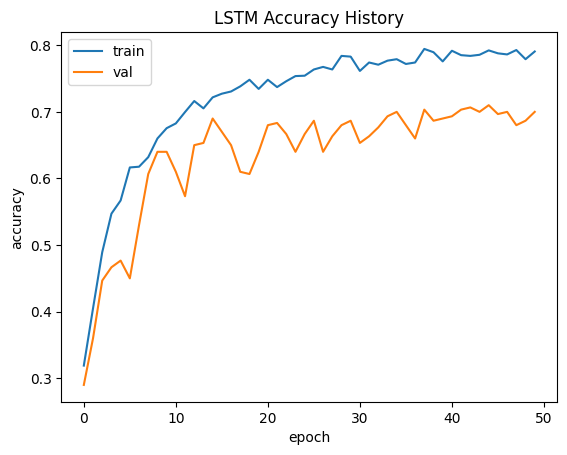

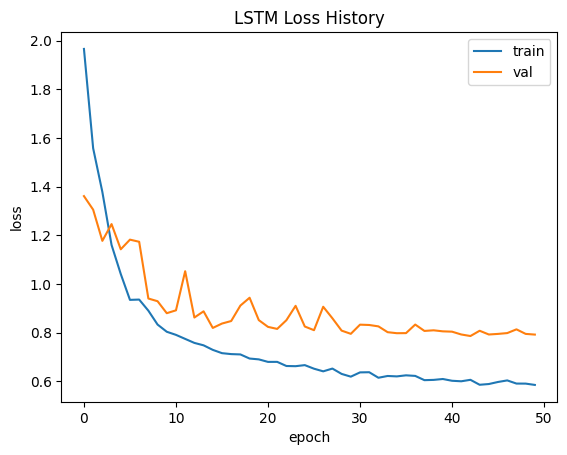

In [33]:
train_acc_history_moved = [x.cpu() for x in train_acc_history]
val_acc_history_moved = [x.cpu() for x in val_acc_history]
train_loss_history_conv = [x.item() for x in train_loss_history]
val_loss_history_conv = [x.item() for x in val_loss_history]

# Plotting accuracy trajectory
plt.plot(train_acc_history_moved, label="train")
plt.plot(val_acc_history_moved, label="val")
plt.title('LSTM Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
plt.plot(train_loss_history_conv, label="train")
plt.plot(val_loss_history_conv, label="val")
plt.title('LSTM Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [34]:
X_test = X_test.float().to(device)
y_test = y_test.long().to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    loss = cel_loss(logits, y_test)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Test loss: {loss:.3f}, Test acc: {test_acc:.3f}")

Test loss: 0.823, Test acc: 0.657


## CNN + LSTM 1

2 Convolution Blocks and 1 LSTM Block achieve 52.6% accuracy

In [75]:
class SmallConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, norm=False, dropout=False):
        super(SmallConvBlock, self).__init__()
        self.norm = norm
        self.dropout = dropout

        # conv -> relu -> pool -> (batch norm) -> (dropout)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same")
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(3)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        if (self.norm):
            x = self.bn1(x)
        if (self.dropout):
            x = self.drop1(x)
        return x

class SmallBlock (nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=False, norm=False):
        super(SmallBlock, self).__init__()
        self.norm = norm
        self.dropout = dropout

        # lstm -> relu -> (norm) -> pool -> dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(3)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.drop1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.relu1(x)
        x = self.maxpool1(x.permute(0, 2, 1)).permute(0, 2, 1)

        if (self.norm):
            x = self.bn1(x.permute(0, 2, 1)).permute(0, 2, 1)
        if (self.dropout):
            x = self.drop1(x)
        return x


class CNNLSTM1(nn.Module):
    def __init__(self):
        super(CNNLSTM1, self).__init__()

        # start: 22 x 500
        self.cblock1 = SmallConvBlock(22, 128, 5, dropout=True, norm=False)
        self.cblock2 = SmallConvBlock(128, 256, 5, dropout=True, norm=True)
        self.lstm1 = SmallBlock(256, 512, dropout=True, norm=False)
        self.output = nn.Linear(512 * 18, 4)

    def forward(self, x):
        x = self.cblock1(x)
        x = self.cblock2(x)

        x = x.permute(0, 2, 1)
        x = self.lstm1(x)
        x = x.reshape(x.size(0), -1)
        x = self.output(x)
        return x

def weights_init(m):
    if isinstance(m, (nn.LSTM, nn.Linear, nn.Conv1d)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

In [76]:
model = CNNLSTM1().to(device)
model.apply(weights_init)

CNNLSTM1(
  (cblock1): SmallConvBlock(
    (conv1): Conv1d(22, 128, kernel_size=(5,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (cblock2): SmallConvBlock(
    (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (lstm1): SmallBlock(
    (lstm1): LSTM(256, 512, batch_first=True)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1)

In [77]:
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)

In [78]:
num_epochs = 100

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    train_count = 0
    train_correct_count = 0
    train_loss = 0
    val_count = 0
    val_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad()
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        train_loss += loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc)

    model.eval()
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            loss = cel_loss(logits, val_y)
            val_loss += loss
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_acc)
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")



Epoch 1, Train loss: 1.383, Train acc: 0.314, Val loss: 1.348, Val acc: 0.287
Epoch 2, Train loss: 1.265, Train acc: 0.419, Val loss: 1.240, Val acc: 0.437
Epoch 3, Train loss: 1.219, Train acc: 0.453, Val loss: 1.178, Val acc: 0.493
Epoch 4, Train loss: 1.194, Train acc: 0.468, Val loss: 1.235, Val acc: 0.423
Epoch 5, Train loss: 1.212, Train acc: 0.449, Val loss: 1.220, Val acc: 0.427
Epoch 6, Train loss: 1.180, Train acc: 0.481, Val loss: 1.207, Val acc: 0.517
Epoch 7, Train loss: 1.174, Train acc: 0.492, Val loss: 1.260, Val acc: 0.433
Epoch 8, Train loss: 1.153, Train acc: 0.502, Val loss: 1.146, Val acc: 0.550
Epoch 9, Train loss: 1.145, Train acc: 0.515, Val loss: 1.139, Val acc: 0.523
Epoch 10, Train loss: 1.150, Train acc: 0.517, Val loss: 1.141, Val acc: 0.523
Epoch 11, Train loss: 1.124, Train acc: 0.523, Val loss: 1.163, Val acc: 0.480
Epoch 12, Train loss: 1.129, Train acc: 0.521, Val loss: 1.143, Val acc: 0.540
Epoch 13, Train loss: 1.122, Train acc: 0.529, Val loss: 1.21

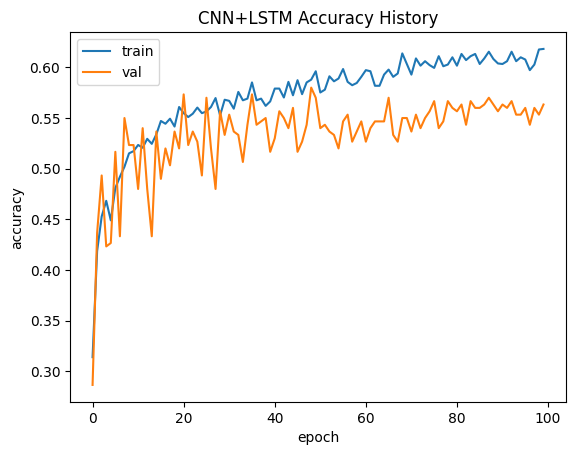

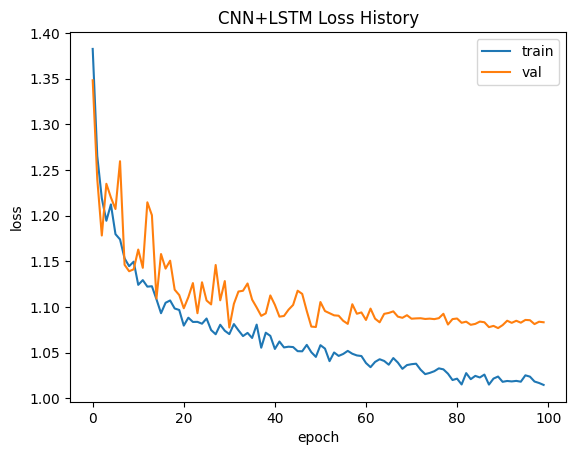

In [79]:
train_acc_history_moved = [x.cpu() for x in train_acc_history]
val_acc_history_moved = [x.cpu() for x in val_acc_history]
train_loss_history_conv = [x.item() for x in train_loss_history]
val_loss_history_conv = [x.item() for x in val_loss_history]

# Plotting accuracy trajectory
plt.plot(train_acc_history_moved, label="train")
plt.plot(val_acc_history_moved, label="val")
plt.title('CNN+LSTM Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
plt.plot(train_loss_history_conv, label="train")
plt.plot(val_loss_history_conv, label="val")
plt.title('CNN+LSTM Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [80]:
X_test = X_test.float().to(device)
y_test = y_test.long().to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    loss = cel_loss(logits, y_test)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Test loss: {loss:.3f}, Test acc: {test_acc:.3f}")


Test loss: 1.120, Test acc: 0.526


## CNN + LSTM 2

3 convolutional blocks and 1 LSTM block achieve 67.9% accuracy.

In [51]:
class CNNLSTM2(nn.Module):
    def __init__(self):
        super(CNNLSTM2, self).__init__()

        # start: 22 x 500
        self.cblock1 = SmallConvBlock(22, 128, 5, dropout=True, norm=False)
        self.cblock2 = SmallConvBlock(128, 256, 5, dropout=True, norm=True)
        self.cblock3 = SmallConvBlock(256, 512, dropout=True, norm=False)
        self.lstm1 = SmallBlock(512, 1024, dropout=True, norm=True)
        self.output = nn.Linear(1024 * 6, 4)

    def forward(self, x):
        x = self.cblock1(x)
        x = self.cblock2(x)
        x = self.cblock3(x)

        x = x.permute(0, 2, 1)
        x = self.lstm1(x)
        x = x.reshape(x.size(0), -1)
        x = self.output(x)
        return x

def weights_init(m):
    if isinstance(m, (nn.LSTM, nn.Linear, nn.Conv1d)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

In [52]:
model = CNNLSTM2().to(device)
model.apply(weights_init)

CNNLSTM2(
  (cblock1): SmallConvBlock(
    (conv1): Conv1d(22, 128, kernel_size=(5,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (cblock2): SmallConvBlock(
    (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (cblock3): SmallConvBlock(
    (conv1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, tr

In [53]:
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)

In [54]:
num_epochs = 100

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    train_count = 0
    train_correct_count = 0
    train_loss = 0
    val_count = 0
    val_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad()
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        train_loss += loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc)

    model.eval()
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            loss = cel_loss(logits, val_y)
            val_loss += loss
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_acc)
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")



Epoch 1, Train loss: 2.294, Train acc: 0.298, Val loss: 1.570, Val acc: 0.337
Epoch 2, Train loss: 1.906, Train acc: 0.340, Val loss: 1.354, Val acc: 0.363
Epoch 3, Train loss: 1.706, Train acc: 0.334, Val loss: 2.186, Val acc: 0.273
Epoch 4, Train loss: 1.631, Train acc: 0.325, Val loss: 1.479, Val acc: 0.310
Epoch 5, Train loss: 1.432, Train acc: 0.381, Val loss: 1.295, Val acc: 0.423
Epoch 6, Train loss: 1.386, Train acc: 0.401, Val loss: 1.161, Val acc: 0.457
Epoch 7, Train loss: 1.268, Train acc: 0.457, Val loss: 1.204, Val acc: 0.450
Epoch 8, Train loss: 1.252, Train acc: 0.475, Val loss: 1.163, Val acc: 0.417
Epoch 9, Train loss: 1.164, Train acc: 0.503, Val loss: 1.154, Val acc: 0.493
Epoch 10, Train loss: 1.128, Train acc: 0.521, Val loss: 1.107, Val acc: 0.537
Epoch 11, Train loss: 1.089, Train acc: 0.540, Val loss: 1.066, Val acc: 0.553
Epoch 12, Train loss: 1.038, Train acc: 0.575, Val loss: 1.105, Val acc: 0.543
Epoch 13, Train loss: 1.027, Train acc: 0.563, Val loss: 0.97

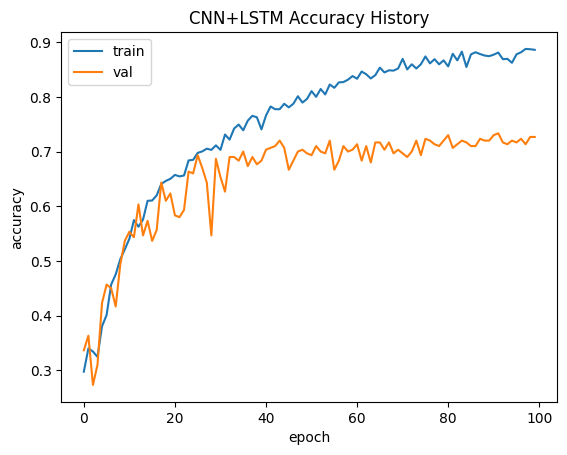

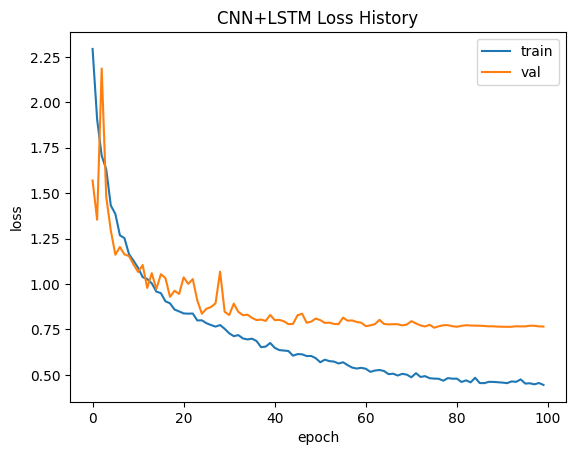

In [55]:
train_acc_history_moved = [x.cpu() for x in train_acc_history]
val_acc_history_moved = [x.cpu() for x in val_acc_history]
train_loss_history_conv = [x.item() for x in train_loss_history]
val_loss_history_conv = [x.item() for x in val_loss_history]

# Plotting accuracy trajectory
plt.plot(train_acc_history_moved, label="train")
plt.plot(val_acc_history_moved, label="val")
plt.title('CNN+LSTM Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
plt.plot(train_loss_history_conv, label="train")
plt.plot(val_loss_history_conv, label="val")
plt.title('CNN+LSTM Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [56]:
X_test = X_test.float().to(device)
y_test = y_test.long().to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    loss = cel_loss(logits, y_test)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Test loss: {loss:.3f}, Test acc: {test_acc:.3f}")


Test loss: 0.836, Test acc: 0.679


## CNN + LSTM 3
1 LSTM Blocks and 3 CNN Blocks achieve 69.1%

In [97]:
class CNNLSTM3(nn.Module):
    def __init__(self):
        super(CNNLSTM3, self).__init__()

        # start: 22 x 500
        self.lstm1 = SmallBlock(22, 128, dropout=True, norm=True)
        self.cblock1 = SmallConvBlock(128, 256, 5, dropout=True, norm=False)
        self.cblock2 = SmallConvBlock(256, 512, 5, dropout=True, norm=False)
        self.cblock3 = SmallConvBlock(512, 1024, 5, dropout=True, norm=True)
        self.output = nn.Linear(1024 * 6, 4)

    def forward(self, x):

        x = x.permute(0, 2, 1)
        x = self.lstm1(x)

        x = x.permute (0, 2, 1)
        x = self.cblock1(x)
        x = self.cblock2(x)
        x = self.cblock3(x)
        x = x.reshape(x.size(0), -1)

        x = self.output(x)
        return x

def weights_init(m):
    if isinstance(m, (nn.LSTM, nn.Linear, nn.Conv1d)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

In [98]:
model = CNNLSTM3().to(device)
model.apply(weights_init)

CNNLSTM3(
  (lstm1): SmallBlock(
    (lstm1): LSTM(22, 128, batch_first=True)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (cblock1): SmallConvBlock(
    (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1): Dropout(p=0.5, inplace=False)
  )
  (cblock2): SmallConvBlock(
    (conv1): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=same)
    (relu1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop1)

In [99]:
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)

In [100]:
num_epochs = 100

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    train_count = 0
    train_correct_count = 0
    train_loss = 0
    val_count = 0
    val_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)
        optimizer.zero_grad()
        logits = model(train_x)
        loss = cel_loss(logits, train_y)
        train_loss += loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc)

    model.eval()
    with torch.no_grad():
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            loss = cel_loss(logits, val_y)
            val_loss += loss
            y_hat = torch.argmax(logits, dim=-1)
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_acc)
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train loss: {train_loss/len(train_loader):.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss/len(val_loader):.3f}, Val acc: {val_acc:.3f}")



Epoch 1, Train loss: 2.454, Train acc: 0.309, Val loss: 3.328, Val acc: 0.253
Epoch 2, Train loss: 1.939, Train acc: 0.367, Val loss: 1.596, Val acc: 0.443
Epoch 3, Train loss: 1.678, Train acc: 0.418, Val loss: 1.268, Val acc: 0.400
Epoch 4, Train loss: 1.436, Train acc: 0.455, Val loss: 1.131, Val acc: 0.467
Epoch 5, Train loss: 1.302, Train acc: 0.482, Val loss: 1.232, Val acc: 0.493
Epoch 6, Train loss: 1.225, Train acc: 0.513, Val loss: 1.094, Val acc: 0.527
Epoch 7, Train loss: 1.165, Train acc: 0.537, Val loss: 1.047, Val acc: 0.560
Epoch 8, Train loss: 1.082, Train acc: 0.572, Val loss: 1.170, Val acc: 0.483
Epoch 9, Train loss: 1.059, Train acc: 0.580, Val loss: 0.973, Val acc: 0.593
Epoch 10, Train loss: 1.022, Train acc: 0.569, Val loss: 0.984, Val acc: 0.590
Epoch 11, Train loss: 0.946, Train acc: 0.636, Val loss: 0.974, Val acc: 0.570
Epoch 12, Train loss: 0.913, Train acc: 0.620, Val loss: 1.032, Val acc: 0.570
Epoch 13, Train loss: 0.897, Train acc: 0.626, Val loss: 0.99

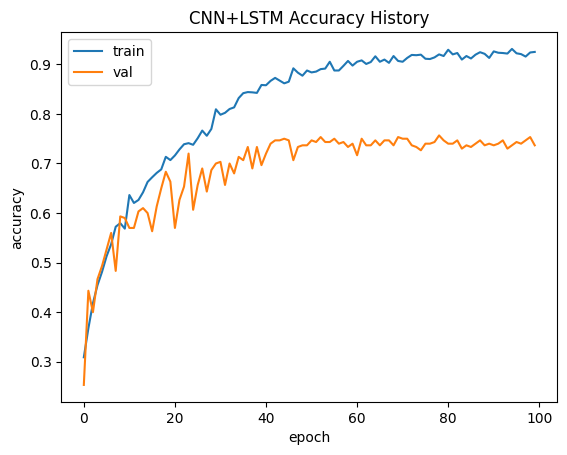

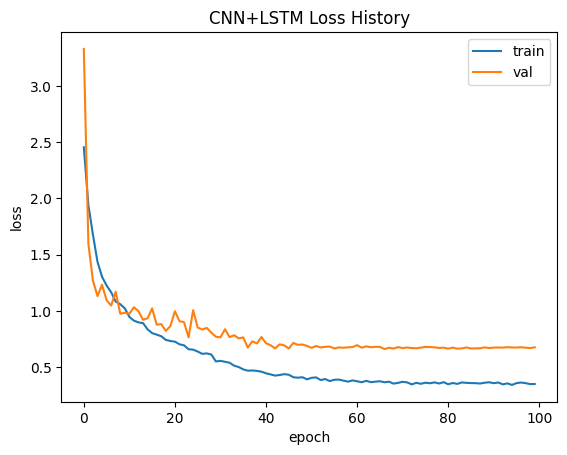

In [101]:
train_acc_history_moved = [x.cpu() for x in train_acc_history]
val_acc_history_moved = [x.cpu() for x in val_acc_history]
train_loss_history_conv = [x.item() for x in train_loss_history]
val_loss_history_conv = [x.item() for x in val_loss_history]

# Plotting accuracy trajectory
plt.plot(train_acc_history_moved, label="train")
plt.plot(val_acc_history_moved, label="val")
plt.title('CNN+LSTM Accuracy History')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plotting loss trajectory
plt.plot(train_loss_history_conv, label="train")
plt.plot(val_loss_history_conv, label="val")
plt.title('CNN+LSTM Loss History')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [103]:
X_test = X_test.float().to(device)
y_test = y_test.long().to(device)

model.eval()
with torch.no_grad():
    logits = model(X_test)
    loss = cel_loss(logits, y_test)
    y_hat = torch.argmax(logits, dim=-1)
    test_acc = torch.sum(y_hat == y_test, axis=-1) / X_test.size(0)
    print(f"Test loss: {loss:.3f}, Test acc: {test_acc:.3f}")


Test loss: 0.779, Test acc: 0.691
